In [2]:
import datetime
import hashlib
import re
import sys
sys.path.append("..")

from IPython.display import SVG, HTML
from matplotlib import pyplot as plt
from matplotlib.colors import rgb2hex
import numpy as np
import tszip
import tskit
import tsconvert

import sc2ts

base_sc2_time = "2021-06-30"  # equivalent of day 0 in the sc2_ts file
sc2_ts = tszip.decompress(f"../results/upgma-full-md-30-mm-3-{base_sc2_time}.ts.tsz")

nwk_string = sc2ts.extract_newick_from_nextstrain_nexus(
    "../results/nextstrain_ncov_gisaid_global_all-time_timetree-2023-01-21.nex")

nextstrain_ts_tmp = sc2ts.newick_from_nextstrain_with_comments(
    nwk_string, min_edge_length=0.0001 * 1/365)

# Below from https://github.com/nextstrain/nextclade_data/tree/release/data/datasets/sars-cov-2/references/MN908947/versions
# nextclade_json_ts = sc2ts.load_nextclade_json("../results/tree.json")  # This has more samples but no branch lengths
sc2_date = datetime.datetime(*[int(x) for x in base_sc2_time.split("-")])

In [3]:
# Remove "samples" without names
keep = [n.id for n in nextstrain_ts_tmp.nodes() if n.is_sample() and "strain" in n.metadata]
nextstrain_ts = nextstrain_ts_tmp.simplify(keep)                       

In [6]:
# Slow: find the samples in sc2_ts also in nextstrain_its, and subsetting down to those
sc2_its, nextstrain_its = sc2ts.subset_to_intersection(
    sc2_ts, nextstrain_ts, filter_sites=False, keep_unary=True)

In [7]:
print("num samples in each", sc2_its.num_samples, nextstrain_its.num_samples)
for u, v in zip(sc2_its.samples(), nextstrain_its.samples()):
    assert sc2_its.node(u).metadata["strain"] == nextstrain_its.node(v).metadata["strain"]

num samples in each 187 180


In [9]:
### Extra filtering

#pos = sc2_its.sequence_length - 1
lft, rgt =  sc2ts.core.get_gene_coordinates()["S"]
pos = (lft + rgt)/2
#pos = sc2_its.sequence_length/2

## Filter from entire TS:
# Some of the samples in sc2_its are recombinants: remove these from both trees
sc2_simp_its = sc2_its.simplify(
    sc2_its.samples()[0:nextstrain_its.num_samples],
    keep_unary=True,
    filter_nodes=False)
assert sc2_simp_its.num_samples == sc2_simp_its.num_samples
for u, v in zip(sc2_simp_its.samples(), nextstrain_its.samples()):
    assert sc2_simp_its.node(u).metadata["strain"] == nextstrain_its.node(v).metadata["strain"]
print(f"Removed {sc2_its.num_samples-sc2_simp_its.num_samples} samples in sc2 not in nextstrain")

## Filter from trees
# Some of the samples in sc2_simp_its are internal. Remove those from both datasets
keep = np.array([u for u in sc2_simp_its.at(pos).leaves()])

# Change the random seed here to change the untangling start point
#rng = np.random.default_rng(777)
#keep = rng.shuffle(keep)
sc2_final_tree = sc2_simp_its.simplify(keep).at(pos)
assert nextstrain_its.num_trees == 1
nextstrain_final_tree = nextstrain_its.simplify(keep).first()
print(
    "Removed internal samples in first tree. Trees now have",
    sc2_final_tree.tree_sequence.num_samples,
    "leaf samples"
)

Removed 7 samples in sc2 not in nextstrain
Removed internal samples in first tree. Trees now have 180 leaf samples


In [ ]:
# Arrange the tips in a nice order using one of the "untangling" algorithms for cophylogenies.
# The only efficient way I have found to do this is to use the "Neighbor Net" untangling
# algorithm (http://dx.doi.org/10.1093/bioinformatics/btr210) implemented in the Java-based
# dendroscope package. To run this, we need to export the two trees (e.g. to Newick format)
# run the command-line version of dendroscope, and re-import
import os
import tempfile
import subprocess
import re

# Redefine the path to your local dendroscope Java app here
dendroscope_binary = "/Applications/Dendroscope/Dendroscope.app/Contents/MacOS/JavaApplicationStub"


def run_nnet_untangle(trees):
    assert len(trees) == 2
    with tempfile.TemporaryDirectory() as tmpdirname:
        newick_path = os.path.join(tmpdirname, "cophylo.nwk")
        command_path = os.path.join(tmpdirname, "commands.txt")
        with open(newick_path, "wt") as file:
            for tree in trees:
                print(tree.as_newick(), file=file)
        with open(command_path, "wt") as file:
            print(f"open file='{newick_path}';", file=file)
            print("compute tanglegram method=nnet", file=file)
            print(f"save format=newick file='{newick_path}'", file=file) # overwrite
            print("quit;", file=file)
        subprocess.run([dendroscope_binary, "-g", "-c", command_path])
        order = []
        with open(newick_path, "rt") as newicks:
            for line in newicks:
                # hack: use the order of `nX encoded in the string
                order.append([int(n[1:]) for n in re.findall(r'n\d+', line)])
    return order

sc2_order, ns_order = run_nnet_untangle([sc2_final_tree, nextstrain_final_tree])


Version   Dendroscope (version 3.8.5, built 7 Dec 2022)
Author(s) Daniel H. Huson, with some contributions from other authors
Copyright (C) 2022 Daniel H. Huson. This program comes with ABSOLUTELY NO WARRANTY.
This is free software, licensed under the terms of the GNU General Public License, Version 3.
Java version: 18.0.2.1

Trees loaded: 2
Compute tanglegram: Initialization
Neighbor-net heuristic


In [16]:
# Define functions to map days from 1/1/2020 to times in the two different trees
base_date = datetime.datetime(2020, 1, 1)
timediff = []
for s1, s2 in zip(sc2_final_tree.tree_sequence.samples(), nextstrain_final_tree.tree_sequence.samples()):
    n1 = sc2_final_tree.tree_sequence.node(s1)
    n2 = nextstrain_final_tree.tree_sequence.node(s2)
    assert n1.metadata["strain"] == n2.metadata["strain"]
    timediff.append(n1.time - n2.time)
timediff = np.median(timediff)
def sc2_days_from_2020(days, base_date):
    "Convert time in in days since base_date to sc2 time"
    return (sc2_date - base_date).days - days

def ns_days_from_2020(days, base_date):
    "Convert time in in days since base_date to sc2 time"
    return (sc2_date - base_date).days - days - timediff

In [17]:
sc2_order_final =  sc2_final_tree.tree_sequence.simplify(sc2_order).at(pos, sample_lists=True)
ns_rev_order = list(reversed(ns_order)) # We rotate the right hand tree, so we need to reverse the order
ns_order_final =  nextstrain_final_tree.tree_sequence.simplify(ns_rev_order).first(sample_lists=True)

def name_order(tree):
    return {tree.tree_sequence.node(v).metadata["strain"]: i
        for i, v in enumerate(u for u in tree.nodes(order="minlex_postorder") if tree.is_leaf(u))
    }

cmap = plt.get_cmap("tab20b", 50)

pp = {n.metadata.get("comment", {}).get("pango_lineage", "") for n in ns_order_final.tree_sequence.nodes()}

colours = {
    # Name in ns comment metadata, colour scheme
    "Pango": {"md_key": "pango_lineage", "scheme": sc2ts.pango_colours},
    "Nextclade": {"md_key": "clade_membership", "scheme": sc2ts.ns_clade_colours},
    "PangoMpl": {"md_key": "pango_lineage", "scheme": {k: rgb2hex(cmap(i)) for i, k in enumerate(pp)}},
    "PangoB.1.1": {"md_key": "pango_lineage", "scheme": {k: ("#FF0000" if k == ("B.1.1") else "#000000") for i, k in enumerate(pp)}},
}

use_colour = "Pango"
col = colours[use_colour]

# NB - lots of the graphics parameters below such as pixel translations etc are hard-coded to work for
# this particular size of plot (800 x 400) and number of tips. This is a hack: ideally we should
# work out the formulae required for size X by Y and N tips.

global_styles = [
    ".left_tree .tree .node > .lab {text-anchor: end; transform: rotate(90deg) translate(-10px, 10px); font-size: 12px}",
    ".left_tree .tree .leaf > .lab {text-anchor: start; transform: rotate(90deg) translate(6px)}",
    ".lab {font-size: 9px}",
    #".node > .sym {}"
    ".left_tree .y-axis {transform: translateX(-10px)}",
    ".left_tree .y-axis .title text {transform: translateX(30px) rotate(90deg)}",  
    ".left_tree .y-axis .lab {transform: translateX(-4px) rotate(90deg); text-anchor: middle}",
    ".right_tree .tree .node > .lab {text-anchor: start; transform: rotate(-90deg) translate(10px, 10px); font-size: 12px}",
    ".right_tree .tree .leaf > .lab {text-anchor: end; transform: rotate(-90deg) translate(-6px)}",
    ".right_tree .y-axis {transform: translateX(734px)}",
    ".right_tree .y-axis .title text {transform: translateY(40px) translateX(85px) rotate(-90deg)}",
    ".right_tree .y-axis .ticks {transform: translateX(5px)}",
    ".right_tree .y-axis .lab {transform: translateX(11px) rotate(-90deg); text-anchor: middle}",
]

sc2_strain_id_map = {
    sc2_order_final.tree_sequence.node(n).metadata['strain']: n
    for n in sc2_order_final.tree_sequence.samples()
    if 'strain' in sc2_order_final.tree_sequence.node(n).metadata
}

# Assign colours
ns_styles = []
sc2ts_styles = []
legend = {}
for n in ns_order_final.tree_sequence.nodes():
    clade = n.metadata.get("comment", {}).get(col["md_key"], None)
    strain = n.metadata.get("strain", None)
    if clade is not None:
        if clade in col["scheme"]:
            legend[clade] = col['scheme'][clade]
            ns_styles.append(f".nextstrain_tree .n{n.id} .edge {{stroke: {col['scheme'][clade]}}}")
            equivalent_node = n.metadata.get("strain", "")
            if equivalent_node in sc2_strain_id_map:
                sc2ts_styles.append(
                    f".sc2ts_tree .n{sc2_strain_id_map[strain]} .edge {{stroke: {col['scheme'][clade]}}}")

# Find shared splits - use a hash to summarise the samples under a node, otherwise they get big
ns_split_hashes = {
    hashlib.blake2b(" ".join(sorted([
        ns_order_final.tree_sequence.node(s).metadata["strain"]
        for s in ns_order_final.samples(u)])).encode(), digest_size=20).digest(): u
    for u in ns_order_final.nodes()
    if not ns_order_final.is_sample(u)
}

sc2ts_split_hashes = {
    hashlib.blake2b(" ".join(sorted([
        sc2_order_final.tree_sequence.node(s).metadata["strain"]
        for s in sc2_order_final.samples(u)])).encode(), digest_size=20).digest(): u
    for u in sc2_order_final.nodes()
    if not sc2_order_final.is_sample(u)
}

shared_split_keys = set(ns_split_hashes.keys()).intersection(set(sc2ts_split_hashes.keys()))
for shared_split_key in shared_split_keys:
    ns_styles.append(f".nextstrain_tree .n{ns_split_hashes[shared_split_key]} > .sym {{r: 3px}}")
    sc2ts_styles.append(f".sc2ts_tree .n{sc2ts_split_hashes[shared_split_key]} > .sym {{r: 3px}}")

focal_nodes = {"Delta": {}, "Alpha": {}}
for nm, tree in zip(("sc2ts", "nextstrain"), (sc2_order_final, ns_order_final)):
    delta = []
    alpha = []
    for node in tree.tree_sequence.nodes():
        if node.is_sample():
            if nm == "nextstrain":
                pango = node.metadata.get("comment", {}).get("pango_lineage", "")
            else:
                pango = node.metadata.get("Nextclade_pango", "")
            if pango.startswith("AY") or pango == "B.1.617.2":
                delta.append(node.id)
            if pango == "B.1.1.7":
                alpha.append(node.id)
    focal_nodes["Delta"][nm] = tree.mrca(*delta)
    focal_nodes["Alpha"][nm] = tree.mrca(*alpha)
    
sc2ts_node_labels = {n.id: n.metadata.get("strain", "") for n in sc2_order_final.tree_sequence.nodes()}
sc2ts_node_labels.update({focal_nodes[k]['sc2ts']: k for k in focal_nodes})

svg1 = sc2_order_final.draw_svg(
    size=(800, 400),
    canvas_size=(800, 800),
    node_labels=sc2ts_node_labels,
    root_svg_attributes = {"class": "sc2ts_tree"},
    mutation_labels={},
    omit_sites=True,
    symbol_size=1,
    y_axis=True,
    y_ticks={
        sc2_days_from_2020(days, base_date): ("" if month is None else (f"2020-{month:02d}" if days < 365 else f"2021-{month:02d}"))
        for month, days in zip(
            [1, None, None, 4, None, None, 7, None, None, 10, None, None, 1, None, None, 4, None, None],
            np.cumsum([0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30]))},
    y_label=" ",
)

ns_node_labels = {n.id: n.metadata.get("strain", "") for n in ns_order_final.tree_sequence.nodes()}
ns_node_labels.update({focal_nodes[k]['nextstrain']: k for k in focal_nodes})

svg2 = ns_order_final.draw_svg(
    size=(800, 400),
    canvas_size=(900, 800),  # A bit wider to allow for placing the time axis at the other side of the tree
    node_labels = ns_node_labels,
    root_svg_attributes = {"class": "nextstrain_tree"},
    mutation_labels={},
    omit_sites=True,
    symbol_size=1,
    y_axis=True,
    y_ticks={
        ns_days_from_2020(days, base_date): ("" if month is None else (f"2020-{month:02d}" if days < 365 else f"2021-{month:02d}"))
        for month, days in zip(
            [1, None, None, 4, None, None, 7, None, None, 10, None, None, 1, None, None, 4, None, None],
            np.cumsum([0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30]))},
    y_label=" ",
)

names_lft = name_order(sc2_order_final)
names_rgt = name_order(ns_order_final)
min_lft_time = sc2_order_final.tree_sequence.nodes_time[sc2_order_final.tree_sequence.samples()].min()
min_rgt_time = ns_order_final.tree_sequence.nodes_time[ns_order_final.tree_sequence.samples()].min()

loc = {}
for nm in names_lft.keys():
    lft_node = names_lft[nm]
    lft_rel_time = (sc2_order_final.time(lft_node) - min_lft_time) / (sc2_order_final.time(sc2_order_final.root)-min_lft_time)
    rgt_node = names_rgt[nm]
    rgt_rel_time = (ns_order_final.time(rgt_node) - min_rgt_time) / (ns_order_final.time(ns_order_final.root)-min_rgt_time)
    loc[nm]={
        'lft': (370 - lft_rel_time * 340, 763 - lft_node * ((800 - 77) / sc2_order_final.num_samples()) - 22),
        'rgt':(430 + rgt_rel_time * 340, rgt_node * ((800 - 77) / ns_order_final.num_samples()) + 22)
    }

global_styles += [
    # hide node labels by default
    "#main .node > .sym ~ .lab {display: none}"
    # Unless the adjacent node or the label is hovered over
    "#main .node > .sym:hover ~ .lab {display: inherit}"
    "#main .node > .sym ~ .lab:hover {display: inherit}"
]

global_styles += [
    # hide mutation labels by default
    "#main .mut .sym ~ .lab {display: none}"
    # Unless the adjacent node or the label is hovered over
    "#main .mut .sym:hover ~ .lab {display: inherit}"
    "#main .mut .sym ~ .lab:hover {display: inherit}"
]

# override the labels for Delta and Alpha
global_styles += [
    f"#main .{nm}_tree .n{u} > .sym ~ .lab {{stroke: none; fill: black; font-weight: normal; display: inherit}}"
    for v in focal_nodes.values()
    for nm, u in v.items()
]

global_styles += [
    # These are optional, but setting the label text to bold with grey stroke and
    # black fill serves to make black text readable against a black tree 
    "svg#main {background-color: white}",
    "#main .tree .plotbox .lab {stroke: #CCC; fill: black; font-weight: bold}",
    "#main .tree .mut .lab {stroke: #FCC; fill: red; font-weight: bold}",
]

global_styles += ns_styles
global_styles += sc2ts_styles

svg_string = (
    '<svg baseProfile="full" height="800" version="1.1" width="900" id="main"' +
    ' xmlns="http://www.w3.org/2000/svg" ' +
    'xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink">' +
    f'<defs><style>{"".join(global_styles)}</style></defs>'
    f'<text text-anchor="middle" transform="translate(200, 12)">SC2ts tree @ position {int(pos)}</text>' +
    '<text text-anchor="middle" transform="translate(600, 12)">Nextstrain tree</text>' +
    '<g>' + ''.join([
        f'<line x1="{v["lft"][0]}" y1="{v["lft"][1]}" x2="{v["rgt"][0]}" y2="{v["rgt"][1]}" stroke="#CCCCCC" />'
        for v in loc.values()
        ])+
    '</g>' +
    '<g class="left_tree" transform="translate(0 800) rotate(-90)">' +
    svg1 +
    '</g><g class="right_tree" transform="translate(800 -37) rotate(90)">' +
    svg2 +
    '</g>' + 
    '<g class="legend" transform="translate(800 30)">' +
    f'<text>{use_colour} lineage</text>' +
    "".join(f'<line x1="0" y1="{25+i*15}" x2="15" y2="{25+i*15}" stroke-width="2" stroke="{legend[nm]}" /><text font-size="10pt" x="20" y="{30+i*15}">{nm}</text>' for i, nm in enumerate(sorted(legend))) +
    '</g>' + 
    '</svg>'
)
    
with open("cophylogeny.svg", "wt") as file:
    file.write(svg_string)
HTML(svg_string)

In [18]:
sc2_order_final.tree_sequence.node(0)

Node(id=0, flags=1, time=519.0, population=-1, individual=-1, metadata={'Nextclade_pango': 'A', 'clade': '19B', 'country': 'USA', 'date': '2020-01-28', 'date_submitted': '2020-02-11', 'gisaid_epi_isl': 'EPI_ISL_410045.2', 'host': 'Human', 'qc.frameShifts.status': 'good', 'qc.missingData.status': 'good', 'qc.mixedSites.status': 'good', 'qc.stopCodons.status': 'good', 'sc2ts_qc': {'num_masked_sites': 27, 'original_base_composition': {'-': 21, 'A': 8934, 'C': 5492, 'G': 5862, 'T': 9594}, 'original_md5': 'b93214ff0a9a0d6bc8ad75218efe5efc'}, 'strain': 'USA/IL-CDC-03037667-001/2020', 'totalSubstitutions': 7.0})

In [19]:
ns_order_final.tree_sequence.node(200)

Node(id=200, flags=0, time=711.5584144218885, population=-1, individual=-1, metadata={'comment': {'S1_mutations': '6', 'clade_membership': '20I Alpha V1', 'emerging_lineage': '20I Alpha V1', 'mutational_fitness': '0.4611102627', 'num_date': '2021.096978044097', 'num_date_CI': '{2021.0230500940536,2021.113698630137}', 'region': 'Europe'}, 'strain': 'NODE_0000340'})

In [11]:
# find the subset again but keep the node IDs
ts, _ = sc2ts.subset_to_intersection(
    sc2_ts, nextstrain_ts, filter_sites=False, filter_nodes=False, keep_unary=True)
print(ts.num_samples, ts.num_nodes, sc2_ts.num_nodes)

187 1453347 1453347


In [12]:
tree = ts.first()
untouched_by_recomb = []
for sample in ts.samples():
    u = sample
    affected_by_recomb = False
    while u != -1:
        e = ts.edge(tree.edge(u))
        if e.left != 0 or e.right != ts.sequence_length:
            affected_by_recomb = True
            break
        u = tree.parent(u)
    if not affected_by_recomb:
        untouched_by_recomb.append(sample)

In [13]:
simp = ts.simplify([s for s in ts.samples() if s not in set(untouched_by_recomb)],
                   keep_unary=True,
                  filter_nodes=False)

In [14]:
simp.num_trees, simp.num_samples

(8, 29)

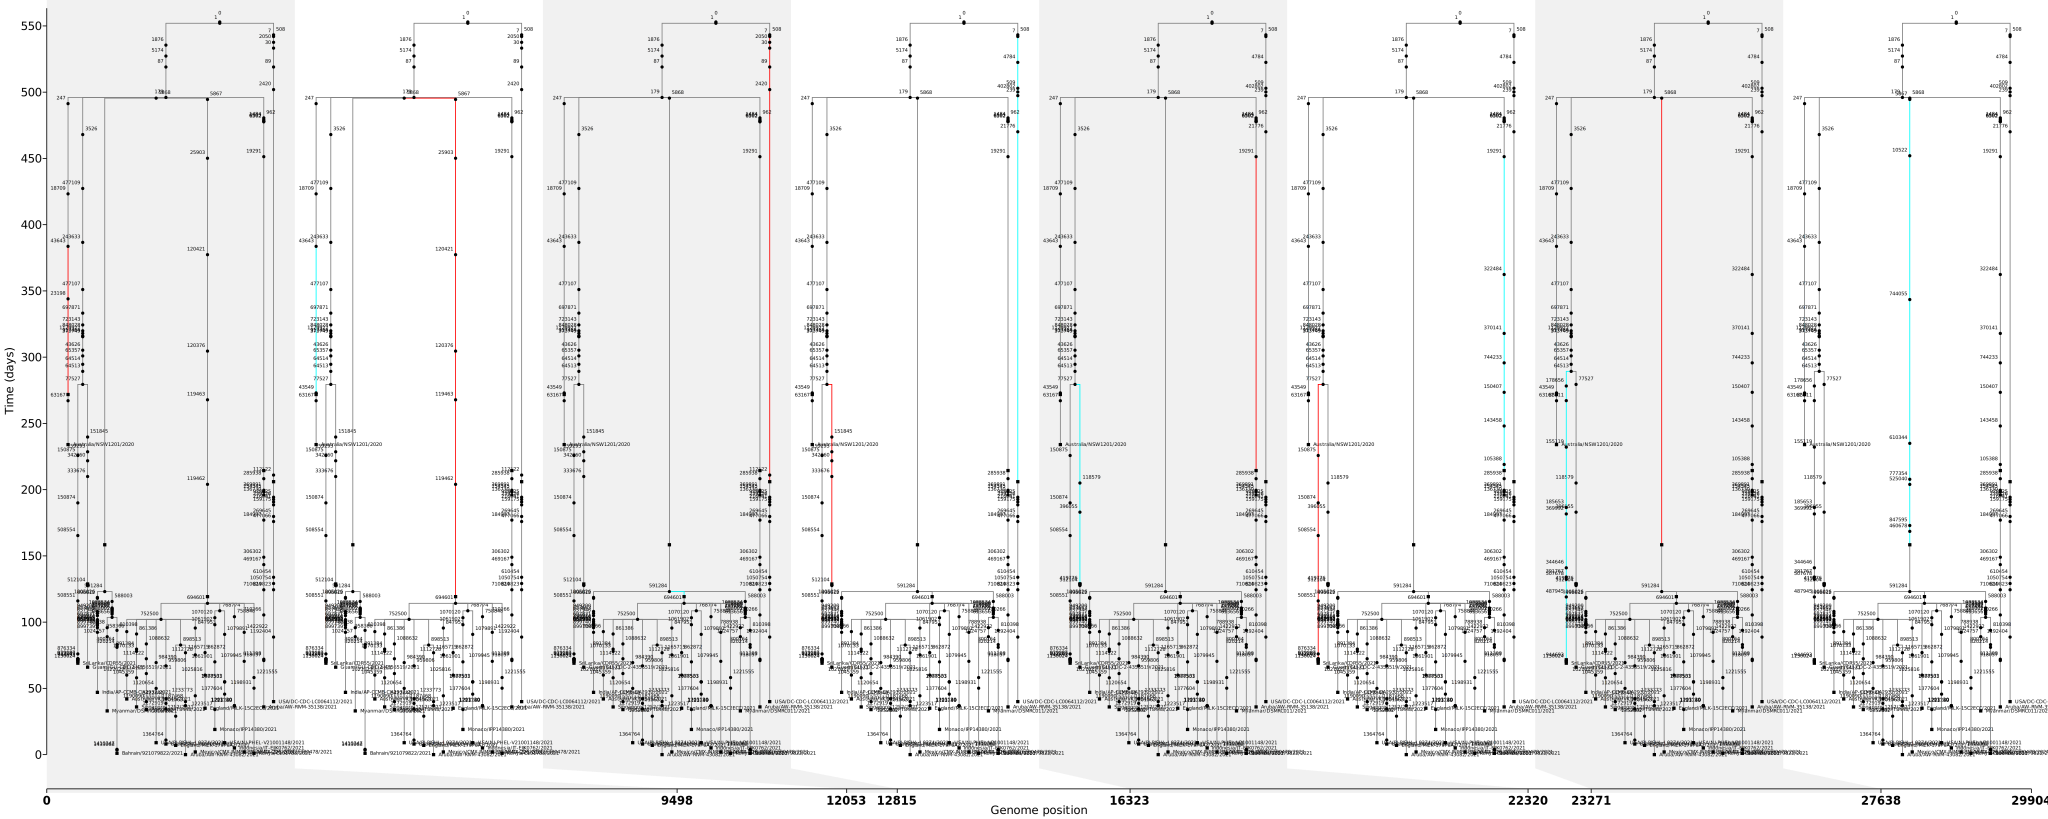

In [15]:
import collections

style = ".node .lab {font-size:6px} .leaf .lab {text-anchor: start; transform: rotate(90deg) translate(6px)}"
style += ".edge {stroke: grey}"
e_out = collections.defaultdict(set)
e_in = collections.defaultdict(set)
for tree_id, ed in enumerate(simp.edge_diffs()):
    if ed.interval.left != 0:
        for i in ed.edges_in:
            e_in[tree_id].add((i.parent, i.child))
    for o in ed.edges_out:
        e_out[tree_id - 1].add((o.parent, o.child))
style += ''.join([
    f".t{tree} .a{c[0]}.n{c[1]} > .edge {{stroke: red}}"
    for tree, edges in e_out.items()
    for c in edges])
style += ''.join([
    f".t{tree} .a{c[0]}.n{c[1]} > .edge {{stroke: cyan}}"
    for tree, edges in e_in.items()
    for c in edges])

shown_nodes = {u for tree in ts.trees() for u in tree.nodes()}

simp.draw_svg(
    size=(2500, 1000),
    style=style,
    y_axis=True,
    symbol_size=4,
    y_ticks = np.arange(0, 600, 50),
    omit_sites=True,
    node_labels={u: (simp.node(u).metadata.get("strain", "") if simp.node(u).is_sample() else u) for u in shown_nodes}
)


In [108]:
## Stuff below for testing the matching functions with small trees

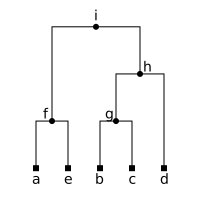

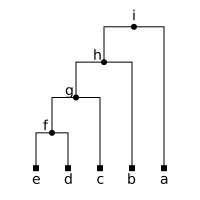

In [97]:
import tskit
import string
import json

tables = tskit.Tree.generate_balanced(5).tree_sequence.dump_tables()
tables.simplify([0,4,3,2,1])
metadata_column = [{"name": string.ascii_lowercase[i]} for i in range(tables.nodes.num_rows)]
tables.nodes.metadata_schema = tskit.MetadataSchema.permissive_json()
tables.nodes.packset_metadata(
    [tables.nodes.metadata_schema.validate_and_encode_row(r) for r in metadata_column]
)
ts1 = tables.tree_sequence()

tables = tskit.Tree.generate_comb(5).tree_sequence.dump_tables()
metadata_column = [{"name": string.ascii_lowercase[i]} for i in range(tables.nodes.num_rows)]
tables.nodes.metadata_schema = tskit.MetadataSchema.permissive_json()
tables.nodes.packset_metadata(
    [tables.nodes.metadata_schema.validate_and_encode_row(r) for r in metadata_column]
)
# reverse the node IDs
ts2 = tables.tree_sequence()
ts2 = ts2.simplify(list(reversed(ts2.samples())))

svg1 = ts1.first().draw_svg(
    root_svg_attributes={"class": "left_tree"},
    #canvas_size=(500, 500),
   node_labels = {n.id: n.metadata["name"] for n in ts1.nodes()}
)

display(svg1)

svg2 = ts2.first().draw_svg(
    root_svg_attributes={"class": "left_tree"},
    #canvas_size=(500, 500),
    node_labels = {n.id: n.metadata["name"] for n in ts2.nodes()}
)

svg2

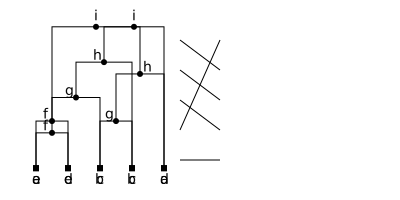

In [98]:
from IPython.display import SVG
def name_order(tree):
    return {tree.tree_sequence.node(v).metadata["name"]:i
        for i, v in enumerate(u for u in tree.nodes(order="minlex_postorder") if tree.is_leaf(u))
    }

names1 = name_order(ts1.first())
names2 = name_order(ts2.first())

SVG('<svg baseProfile="full" height="200" version="1.1" width="400" xmlns="http://www.w3.org/2000/svg" ' +
    'xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink">' +
    '<g lass="left_tree" style="transform: translateY(200px) rotate(-90deg)">' +
    svg1 +
    '</g><g class="right_tree" style="transform: translateX(400px) rotate(90deg)">' +
    svg2 +
    '</g><g class="lines">' +
    "".join([
        f'<line x1="180" y1="{200 - names1[nm] * 30 - 40}" x2="220" y2="{names2[nm] * 30 + 40}" stroke="black" />'
        for nm in names1.keys()
        ])+
    '</g></svg>')
